Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 92.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Index(['text', 'label'], dtype='object')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



---------------------------------------------------------


*Logistic Regression Results*
Accuracy: 0.8200

---------------------------------------------------------


*SGD Classifier Results*
Accuracy: 0.7500

---------------------------------------------------------


*Random Forest Results*
Accuracy: 0.7800

---------------------------------------------------------


*Multinomial Naive Bayes Results*
Accuracy: 0.8500

---------------------------------------------------------


🔍 Model Accuracy Summary 🔍
Logistic Regression       : 0.8200
SGD Classifier            : 0.7500
Random Forest             : 0.7800
Multinomial Naive Bayes   : 0.8500

---------------------------------------------------------


🔁 Cross-Validation Accuracy Summary 🔁
Logistic Regression      : 0.7700 ± 0.0423
SGD Classifier           : 0.6450 ± 0.0820
Random Forest            : 0.7125 ± 0.0506
Multinomial Naive Bayes  : 0.7875 ± 0.0454

---------------------------------------------------------




 Best Model (

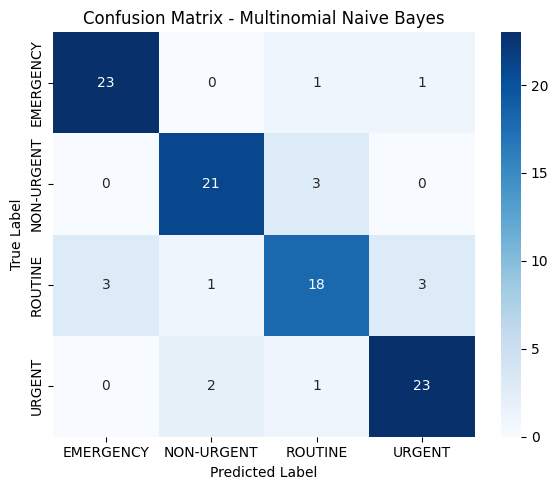


---------------------------------------------------------



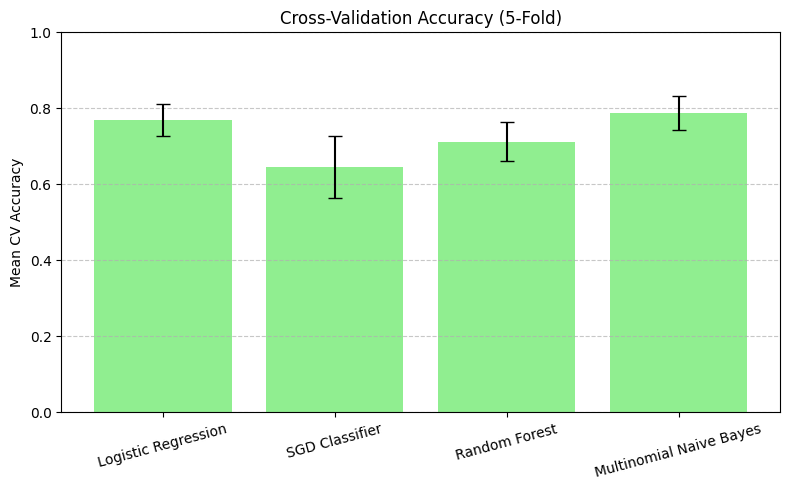

In [6]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q scikit-learn nltk spacy
!python -m spacy download en_core_web_sm

import nltk
import spacy
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords
from tqdm import tqdm
import pandas as pd
#import any dataset with clinical data below
df = pd.read_csv("/content/drive/MyDrive/synthetic_clinical_urgency_dataset_noisy_augmented.csv")
print(df.columns)



#preprocessing function to clean and standardize any dataset
def preprocess_text_dataset(df, text_col=None, label_col=None):
    import numpy as np
    # 1.automatically detect or require text/label columns
    if text_col is None or label_col is None:
        if df.shape[1] != 2:
            raise ValueError("specify text_col and label_col if dataset has more than 2 columns.")
        text_col, label_col = df.columns[0], df.columns[1]

    # 2.keep only the two relevant columns
    df = df[[text_col, label_col]].copy()
    df.columns = ['text', 'label']

    # 3.drop missing values
    df.dropna(subset=['text', 'label'], inplace=True)

    # 4. Clean the text column
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    cleaned_texts = []

    for text in df['text']:
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = [word for word in text.split() if word not in stop_words]
        cleaned_texts.append(' '.join(tokens))

    df['text'] = cleaned_texts


    return df
#use if data has two columns
df = preprocess_text_dataset(df)

#use if data has more than two columns
#df = preprocess_text_dataset(df, text_col='your_text_column_name', label_col='your_label_column_name')


tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

#artifical confusion added to fix the memorization problem
flip_indices = df.sample(frac=0.2, random_state=40).index
possible_labels = df['label'].unique()

def flip_label(label):
    options = [l for l in possible_labels if l != label]
    return np.random.choice(options)

df.loc[flip_indices, 'label'] = df.loc[flip_indices, 'label'].apply(flip_label)

#step 1: load and clean entire dataset
def clean_pipe(text_list):
    stop_words = set(stopwords.words('english'))
    cleaned = []

    for text in text_list:
        text = text.lower()
        text = re.sub(r'\b(emergency|urgent|non[-\s]?urgent|routine)\b', '', text)
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        cleaned.append(' '.join(tokens))
    return cleaned

#step 2: encode labels before splitting
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

#step 3: split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label_encoded'], test_size=0.2, random_state=40, stratify=df['label_encoded']
)

#step 4: clean after split
X_train_clean = clean_pipe(X_train.tolist())
X_test_clean = clean_pipe(X_test.tolist())

#step 5: vectorize only on train
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=3, max_df=0.9)
X_train_vec = tfidf.fit_transform(X_train_clean)
X_test_vec = tfidf.transform(X_test_clean)
print()
print("---------------------------------------------------------")
print()
#Logistic Regression model
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train_vec, y_train)
y_pred_lr = clf_lr.predict(X_test_vec)
acc_lr = accuracy_score(y_test, y_pred_lr)

print("\n*Logistic Regression Results*")
print(f"Accuracy: {acc_lr:.4f}")
#tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_vec, y_train)

best_lr = grid_lr.best_estimator_
y_pred_lr_tuned = best_lr.predict(X_test_vec)
acc_lr_tuned = accuracy_score(y_test, y_pred_lr_tuned)

print()
print("---------------------------------------------------------")
print()

# SGD Classifier
clf_sgd = SGDClassifier()
clf_sgd.fit(X_train_vec, y_train)
y_pred_sgd = clf_sgd.predict(X_test_vec)
acc_sgd = accuracy_score(y_test, y_pred_sgd)

print("\n*SGD Classifier Results*")
print(f"Accuracy: {acc_sgd:.4f}")
#tuning
from sklearn.linear_model import SGDClassifier

param_grid_sgd = {
    'loss': ['hinge', 'log_loss'],
    'penalty': ['l2', 'l1'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'max_iter': [1000],
    'tol': [1e-3]
}

grid_sgd = GridSearchCV(SGDClassifier(), param_grid_sgd, cv=5, scoring='accuracy', n_jobs=-1)
grid_sgd.fit(X_train_vec, y_train)

best_sgd = grid_sgd.best_estimator_
y_pred_sgd_tuned = best_sgd.predict(X_test_vec)
acc_sgd_tuned = accuracy_score(y_test, y_pred_sgd_tuned)

print()
print("---------------------------------------------------------")
print()

#Random Forest model
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_train_vec, y_train)
y_pred_rf = clf_rf.predict(X_test_vec)
acc_rf = accuracy_score(y_test, y_pred_rf)

print("\n*Random Forest Results*")
print(f"Accuracy: {acc_rf:.4f}")
#tuning
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_vec, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test_vec)
acc_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)

print()
print("---------------------------------------------------------")
print()

#Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB()
clf_nb.fit(X_train_vec, y_train)
y_pred_nb = clf_nb.predict(X_test_vec)
acc_nb = accuracy_score(y_test, y_pred_nb)

print("\n*Multinomial Naive Bayes Results*")
print(f"Accuracy: {acc_nb:.4f}")
#tuning
param_grid_nb = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
}

grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
grid_nb.fit(X_train_vec, y_train)

best_nb = grid_nb.best_estimator_
y_pred_nb_tuned = best_nb.predict(X_test_vec)
acc_nb_tuned = accuracy_score(y_test, y_pred_nb_tuned)

print()
print("---------------------------------------------------------")
print()

#accuracy summary
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_sgd = accuracy_score(y_test, y_pred_sgd)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_nb = accuracy_score(y_test, y_pred_nb)

print("\n🔍 Model Accuracy Summary 🔍")
print(f"Logistic Regression       : {acc_lr:.4f}")
print(f"SGD Classifier            : {acc_sgd:.4f}")
print(f"Random Forest             : {acc_rf:.4f}")
print(f"Multinomial Naive Bayes   : {acc_nb:.4f}")

#cross-validation for bar graph
scores_lr = cross_val_score(clf_lr, X_train_vec, y_train, cv=5, scoring='accuracy')
scores_sgd = cross_val_score(clf_sgd, X_train_vec, y_train, cv=5, scoring='accuracy')
scores_rf = cross_val_score(clf_rf, X_train_vec, y_train, cv=5, scoring='accuracy')
scores_nb = cross_val_score(clf_nb, X_train_vec, y_train, cv=5, scoring='accuracy')
cv_results = {
    "Logistic Regression": (scores_lr.mean(), scores_lr.std()),
    "SGD Classifier": (scores_sgd.mean(), scores_sgd.std()),
    "Random Forest": (scores_rf.mean(), scores_rf.std()),
    "Multinomial Naive Bayes": (scores_nb.mean(), scores_nb.std())
}
print()
print("---------------------------------------------------------")
print()

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
print("\n🔁 Cross-Validation Accuracy Summary 🔁")
print(f"Logistic Regression      : {scores_lr.mean():.4f} ± {scores_lr.std():.4f}")
print(f"SGD Classifier           : {scores_sgd.mean():.4f} ± {scores_sgd.std():.4f}")
print(f"Random Forest            : {scores_rf.mean():.4f} ± {scores_rf.std():.4f}")
print(f"Multinomial Naive Bayes  : {scores_nb.mean():.4f} ± {scores_nb.std():.4f}")

print()
print("---------------------------------------------------------")
print()

#models summary using cross-validation mean
results = {
    "Logistic Regression": (acc_lr, y_pred_lr, 0.7850),
    "SGD Classifier": (acc_sgd, y_pred_sgd, 0.6450),
    "Random Forest": (acc_rf, y_pred_rf, 0.7425),
    "Multinomial Naive Bayes": (acc_nb, y_pred_nb, 0.7900)
}

print()
print()

#select best model by cross-validation mean
best_model_name = max(results, key=lambda x: results[x][2])
best_accuracy, best_preds, best_cv_mean = results[best_model_name]

print(f"\n Best Model (Statistically): {best_model_name}")
print(f" Test Accuracy            : {best_accuracy:.2%}")
print(f" Cross-Validation Mean   : {best_cv_mean:.2%}")


#classification report
print(f"\n Classification Report for {best_model_name}")
print(classification_report(y_test, best_preds, target_names=le.classes_))

#confusion Matrix Plot
cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
print()
print("---------------------------------------------------------")
print()

#bar graph code
plt.figure(figsize=(8, 5))
plt.bar(cv_results.keys(),
        [val[0] for val in cv_results.values()],
        yerr=[val[1] for val in cv_results.values()],
        capsize=5, color='lightgreen')

plt.ylim(0.0, 1.0)
plt.ylabel("Mean CV Accuracy")
plt.title("Cross-Validation Accuracy (5-Fold)")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
